# Introduction

<div class="alert alert-block alert-danger">
<b>

THIS NOTEBOOK IS A STUB, CODE IS INCOMPLETE

</b>
</div>

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CelebA Dataset

In [3]:
dataset_location = '/home/marcin/Datasets/img_align_celeba'

In [4]:
datafile = os.path.join(dataset_location, 'img_align_celeba_32x32.npz')
print(datafile)

/home/marcin/Datasets/img_align_celeba/img_align_celeba_32x32.npz


In [5]:
import PIL

In [6]:
all_files = os.listdir(os.path.join(dataset_location, 'img_align_celeba'))

In [7]:
def crop_celeba(img, size):
    assert img.size == (178, 218)
    box = [25, 65, img.width-25, img.height-25]  # crop 25/65/25/25 from left/top/right/bottom
    return img.crop(box)                         # result.size = (128, 128)

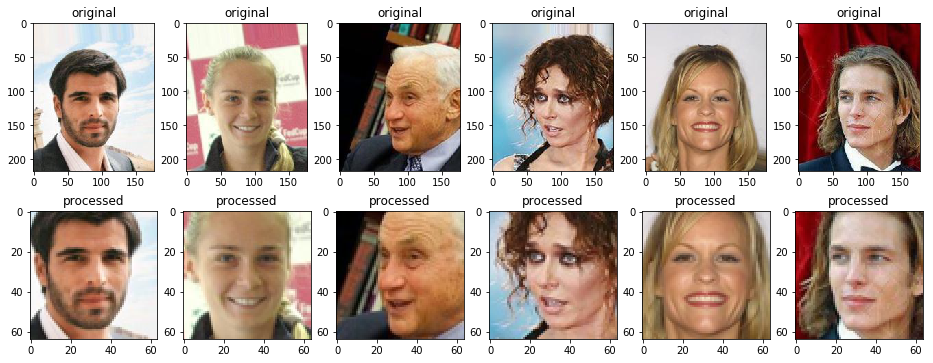

In [8]:
fig, (axes1, axes2) = plt.subplots(nrows=2, ncols=6, figsize=[16,6])
for i in range(len(axes1)):
    idx = np.random.randint(0, len(all_files))
    img_full_path = os.path.join(dataset_location, 'img_align_celeba', all_files[idx])
    img = PIL.Image.open(img_full_path)
    img_128x128 = crop_celeba(img, None)
    img_64x64 = img_128x128.resize([64, 64], PIL.Image.BICUBIC)
    axes1[i].imshow(img)
    axes1[i].set_title('original')
    axes2[i].imshow(img_64x64)
    axes2[i].set_title('processed')

In [9]:
def load_all_images(dataset_location, all_files, size=32):
    all_images = []
    for i in range(len(all_files)):
        img_full_path = os.path.join(dataset_location, 'img_align_celeba', all_files[i])
        img = PIL.Image.open(img_full_path)
        img_128x128 = crop_celeba(img, None)
        img_small = img_128x128.resize([size, size], PIL.Image.BICUBIC)  
        arr = np.array(img_small)
        assert arr.shape == (size, size, 3)
        all_images.append(arr)
        if i % 10000 == 0:
            print(f'Image {i} of {len(all_files)}')
    return np.array(all_images)

In [10]:
# if not os.path.isfile(datafile):
#     print('Creating datafile...')
#     all_images = load_all_images(dataset_location, all_files, size=32)
#     np.savez(datafile, all_images=all_images)
# else:
#     print('Loading from file...')
#     npzfile = np.load(datafile)
#     all_images = npzfile['all_images']

In [11]:
# x_train = (all_images.astype(np.float32) / 127.5) - 1      # scale to range [-1..1]
# x_train = x_train[:-103]                                   # make divisible by 128
# x_train.shape

In [12]:
# del all_images  # save memory

# SVHN Dataset

In [13]:
import torch
from torchvision import datasets
from torchvision import transforms

In [14]:
dataset = datasets.SVHN(root='~/.pytorch/svhn/', split='train', download=True, transform=None)

Using downloaded and verified file: /home/marcin/.pytorch/svhn/train_32x32.mat


In [17]:
x_train = (dataset.data.astype(np.float32) / 127.5) - 1   # scale to range [-1..1]

In [26]:
x_train = x_train[:-41]  # make divisible by 512

In [27]:
print(x_train.shape)

(73216, 3, 32, 32)


In [14]:
# transform = transforms.ToTensor()
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # scaler from 0..1 to -1..1
# ])
# dataset = datasets.SVHN(root='~/.pytorch/svhn/', split='train', download=True, transform=transform)
# dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=128, shuffle=True, num_workers=0)

Using downloaded and verified file: /home/marcin/.pytorch/svhn/train_32x32.mat


Visualize the data

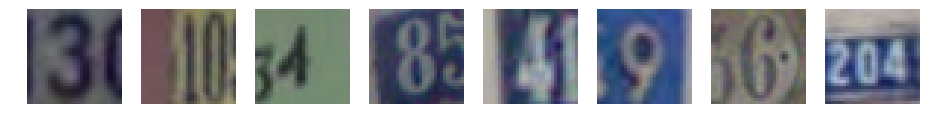

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=[16,6])
for i in range(len(axes)):
    idx = np.random.randint(0, len(x_train))
    img = x_train[idx]
    img = img/2 + .5         # -1..1 -> 0..1
    img = img.transpose(1, 2, 0)
    axes[i].imshow(img); axes[i].axis('off')

**Scale to -1..1**

In [16]:
############
# 

# current range
# img = images[0]

# print('Min: ', img.min())
# print('Max: ', img.max())

In [17]:
############
# 

# # helper scale function
# def scale(x, feature_range=(-1, 1)):
#     ''' Scale takes in an image x and returns that image, scaled
#        with a feature_range of pixel values from -1 to 1. 
#        This function assumes that the input x is already scaled from 0-1.'''
#     # assume x is scaled to (0, 1)
#     # scale to feature_range and return scaled x
#     min, max = feature_range
#     x = x * (max - min) + min
#     return x


In [18]:
############
# 

# # scaled range
# scaled_img = scale(img)

# print('Scaled min: ', scaled_img.min())
# print('Scaled max: ', scaled_img.max())

# DCGAN in PyTorch

Discriminator

In [41]:
############
# 

import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [42]:
############
# 

class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv1 = conv(in_channels=3, out_channels=conv_dim, kernel_size=4, batch_norm=False)
        self.act1 = nn.LeakyReLU(0.2)

        self.conv2 = conv(in_channels=conv_dim, out_channels=2*conv_dim, kernel_size=4, batch_norm=True)
        self.act2 = nn.LeakyReLU(0.2)
        
        self.conv3 = conv(in_channels=2*conv_dim, out_channels=4*conv_dim, kernel_size=4, batch_norm=True)
        self.act3 = nn.LeakyReLU(0.2)
        
        self.fc4 = nn.Linear(in_features=4*conv_dim*4*4, out_features=1)

        
    def forward(self, x):
        # complete forward function
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = x.view(x.size(0), -1) # flatten
        x = self.fc4(x)
        
        return x
    

Generator

In [43]:
############
# 

# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## TODO: Complete this function
    ## create a sequence of transpose + optional batch norm layers
    
    layers = []
    conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                    kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)


In [44]:
############
# 

class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        
        # complete init function
        self.fc0 = nn.Linear(in_features=z_size, out_features=4*conv_dim*4*4)
        
        self.conv1 = deconv(in_channels=4*conv_dim, out_channels=2*conv_dim, kernel_size=4, batch_norm=True)
        self.act1 = nn.ReLU()
        
        self.conv2 = deconv(in_channels=2*conv_dim, out_channels=conv_dim, kernel_size=4, batch_norm=True)
        self.act2 = nn.ReLU()
        
        self.conv3 = deconv(in_channels=conv_dim, out_channels=3, kernel_size=4, batch_norm=False)
        self.act3 = nn.Tanh()
        

    def forward(self, x):
        # complete forward function
        
        x = self.fc0(x)
        x = x.view(x.size(0), 4*self.conv_dim, 4, 4)
        
        x = self.conv1(x)
        x = self.act1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        
        return x
    

DCGAN Model

In [45]:
############
# 

# define hyperparams
conv_dim = 32
z_size = 100

# define discriminator and generator
D = Discriminator(conv_dim)
G = Generator(z_size=z_size, conv_dim=conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (act1): LeakyReLU(negative_slope=0.2)
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (act2): LeakyReLU(negative_slope=0.2)
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (act3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc0): Linear(in_features=100, out_features=2048, bias=True)
  (conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [46]:
###############
# Train on GPU

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')
    

GPU available for training. Models moved to GPU


In [50]:
x_train = torch.tensor(x_train, device=device)

In [52]:
#########
# Losses

def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [53]:
########
# Optimizers

import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [54]:
def plot_images(x_fake):  # Expects tensor shape [batch, 3, width, height]
    fig, axes = plt.subplots(nrows=1, ncols=10, figsize=[16,9])
    for i, ax in enumerate(axes):
        img = x_fake[i].detach().cpu().permute(1, 2, 0).numpy()
        ax.imshow(img/2+.5)
        ax.axis('off')
    plt.show()
    
def plot_loss(losses):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(losses['disc'], label='disc')
    ax.plot(losses['gen'], label='gen')
    plt.show()

In [57]:
n_batch = 128
n_epochs = 5

In [ ]:
torch.random.

Epoch [    0/    5] | d_loss: 1.2903 | g_loss: 0.8234


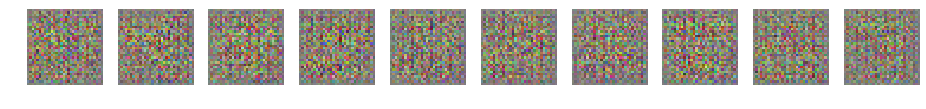

Epoch [    0/    5] | d_loss: 0.0635 | g_loss: 4.0816


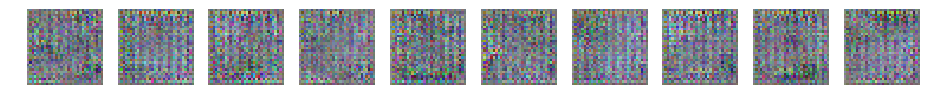

Epoch [    0/    5] | d_loss: 0.3672 | g_loss: 2.8709


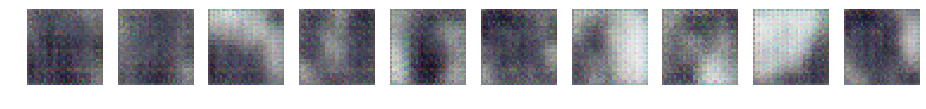

Epoch [    0/    5] | d_loss: 0.5557 | g_loss: 2.4161


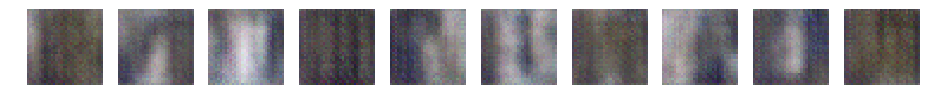

Epoch [    0/    5] | d_loss: 0.7315 | g_loss: 2.5617


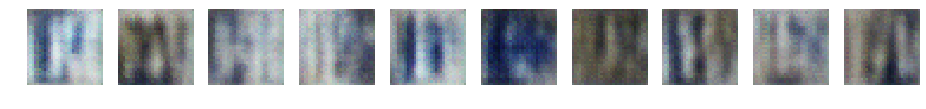

Epoch [    0/    5] | d_loss: 0.3845 | g_loss: 1.9051


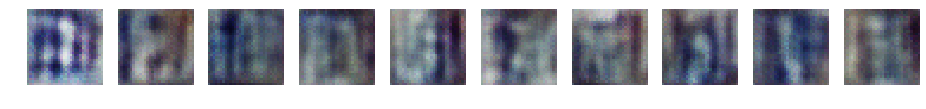

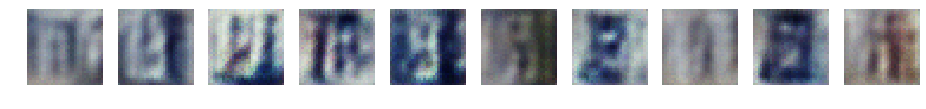

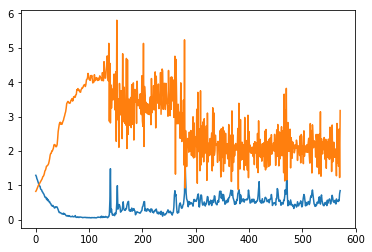

Epoch [    1/    5] | d_loss: 0.9498 | g_loss: 3.4365


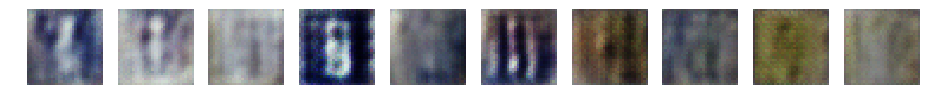

Epoch [    1/    5] | d_loss: 0.7248 | g_loss: 1.2490


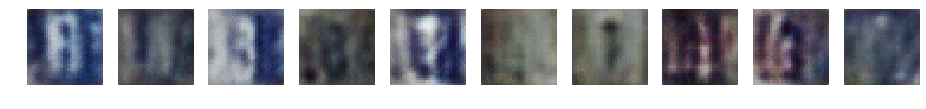

Epoch [    1/    5] | d_loss: 0.8709 | g_loss: 2.1028


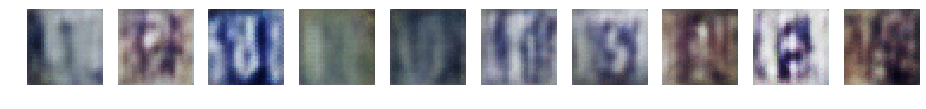

Epoch [    1/    5] | d_loss: 0.8046 | g_loss: 1.3195


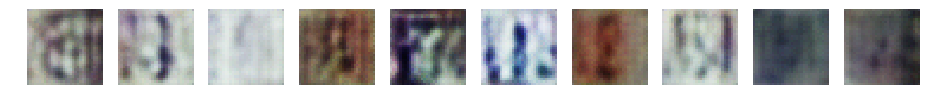

Epoch [    1/    5] | d_loss: 0.6913 | g_loss: 1.2929


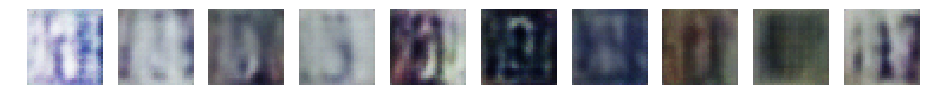

Epoch [    1/    5] | d_loss: 0.7707 | g_loss: 1.3963


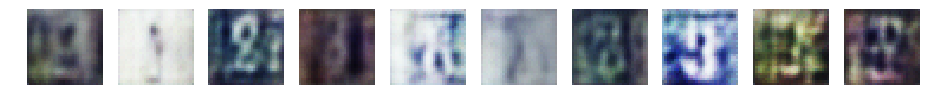

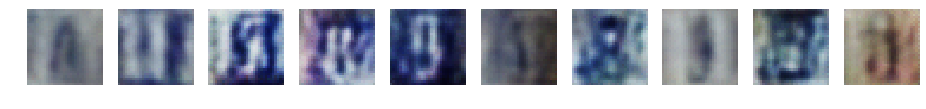

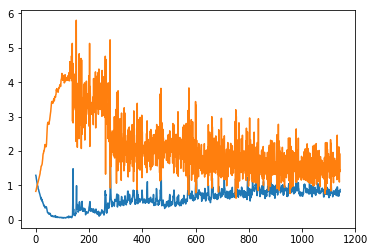

Epoch [    2/    5] | d_loss: 1.0163 | g_loss: 2.7670


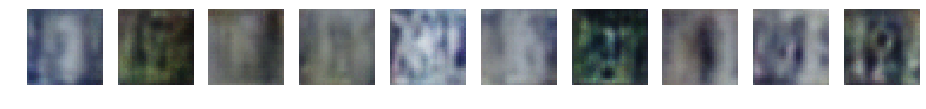

Epoch [    2/    5] | d_loss: 0.7851 | g_loss: 1.1930


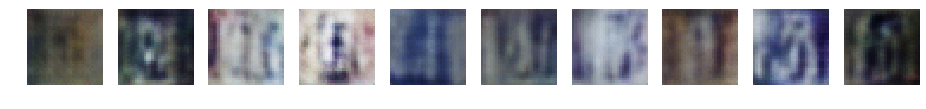

Epoch [    2/    5] | d_loss: 0.6710 | g_loss: 1.3447


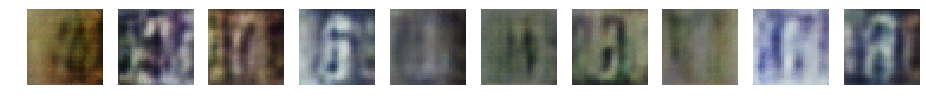

Epoch [    2/    5] | d_loss: 0.9242 | g_loss: 3.2782


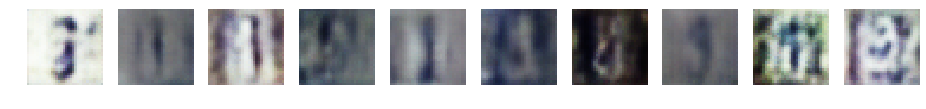

Epoch [    2/    5] | d_loss: 0.9114 | g_loss: 1.3374


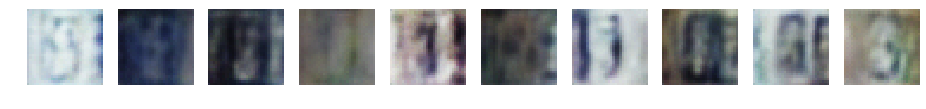

Epoch [    2/    5] | d_loss: 0.7211 | g_loss: 1.5575


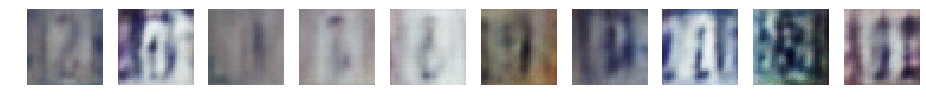

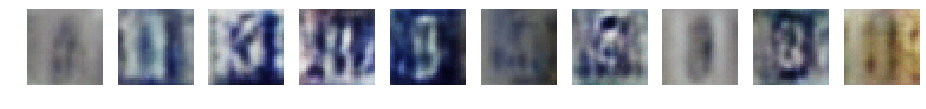

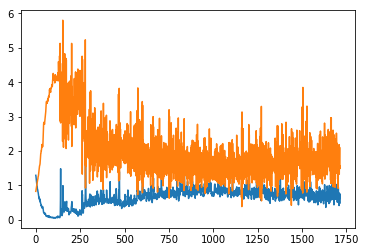

Epoch [    3/    5] | d_loss: 0.5196 | g_loss: 2.0415


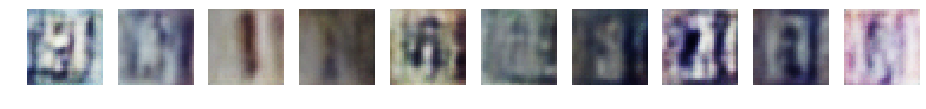

Epoch [    3/    5] | d_loss: 0.5815 | g_loss: 2.2538


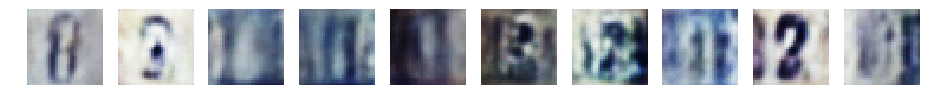

Epoch [    3/    5] | d_loss: 0.7743 | g_loss: 1.1700


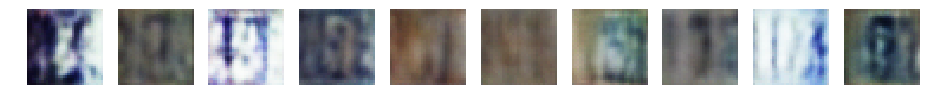

Epoch [    3/    5] | d_loss: 1.1721 | g_loss: 0.5861


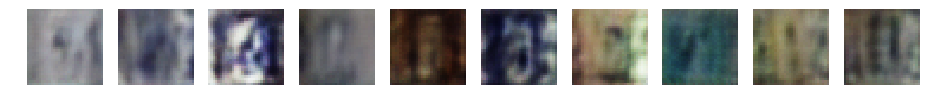

Epoch [    3/    5] | d_loss: 0.8337 | g_loss: 1.9939


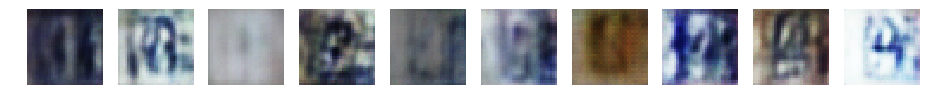

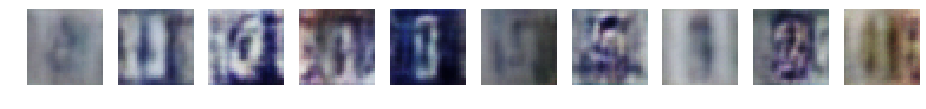

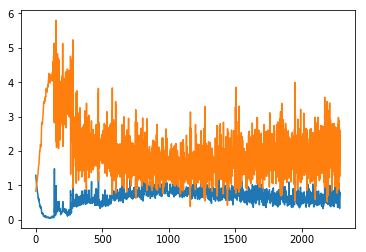

Epoch [    4/    5] | d_loss: 0.5413 | g_loss: 1.3864


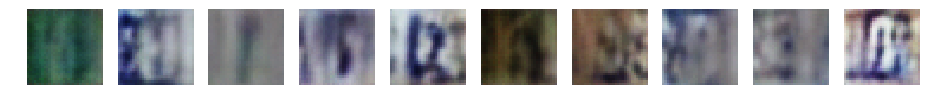

Epoch [    4/    5] | d_loss: 0.6322 | g_loss: 1.7570


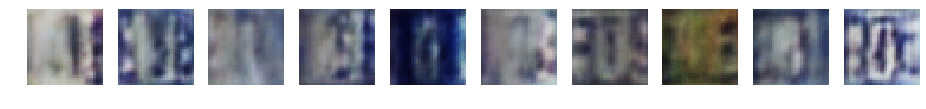

Epoch [    4/    5] | d_loss: 0.4593 | g_loss: 2.6382


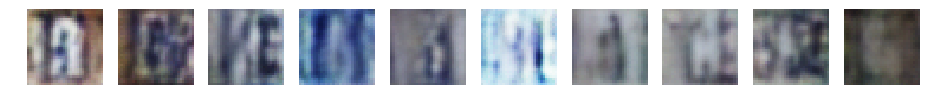

Epoch [    4/    5] | d_loss: 1.1154 | g_loss: 3.4255


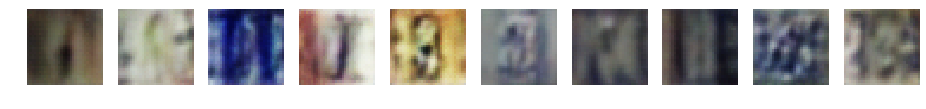

Epoch [    4/    5] | d_loss: 0.3783 | g_loss: 2.6762


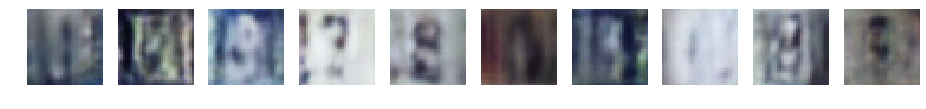

Epoch [    4/    5] | d_loss: 0.2945 | g_loss: 2.3189


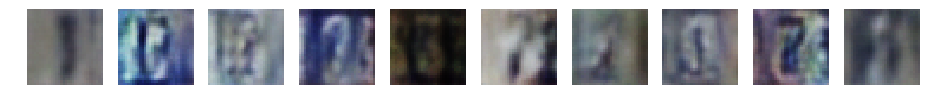

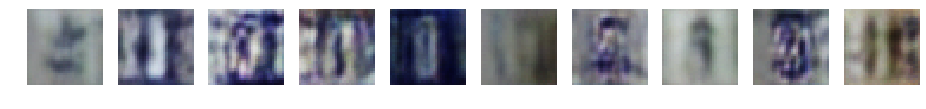

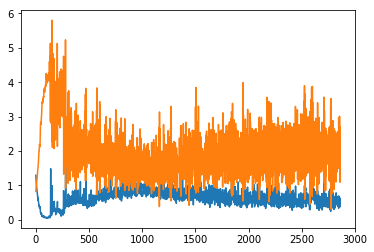

In [59]:
losses = {'gen':[], 'disc':[]}
indices = np.array(range(len(x_train)))

############
# 

batch_i = 0

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
fixed_z = np.random.uniform(-1, 1, size=(16, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
for e in range(n_epochs):
    
    np.random.shuffle(indices)
    
    #for batch_i, (real_images, _) in enumerate(dataloader):
    for i in range(0, len(x_train), n_batch):
        
        # Pick next batch of real images
        i_batch = indices[i:i+n_batch]
        real_images = x_train[i_batch]
                
        batch_size = real_images.size(0)
        
        # important rescaling step
        #real_images = scale(real_images)
        
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        if train_on_gpu:
            real_images = real_images.cuda()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()
        
        # append discriminator loss and generator loss
        losses['disc'].append(d_loss.item())
        losses['gen'].append(g_loss.item())

        # Print some loss stats
        if batch_i % 100 == 0:
            
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    e, n_epochs, d_loss.item(), g_loss.item()))
            
            plot_images(fake_images)
            
        batch_i += 1

    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    G.train() # back to training mode
    
    plot_images(samples_z)
    plot_loss(losses)




Epoch [    1/    5] | d_loss: 1.3889 | g_loss: 0.7880


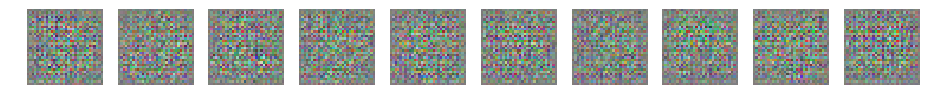

Epoch [    1/    5] | d_loss: 0.1323 | g_loss: 3.0530


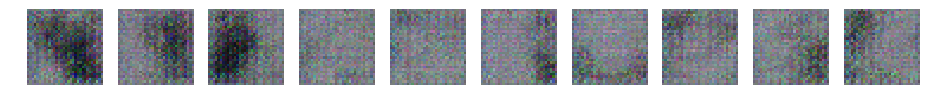

Epoch [    1/    5] | d_loss: 0.1611 | g_loss: 4.3255


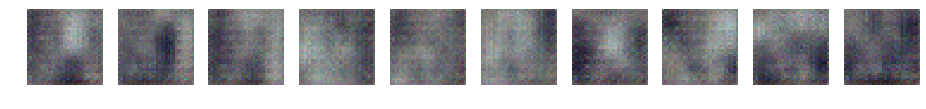

Epoch [    1/    5] | d_loss: 0.3078 | g_loss: 2.5347


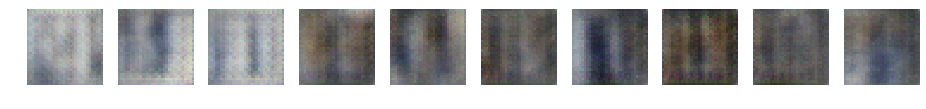

Epoch [    1/    5] | d_loss: 0.4609 | g_loss: 1.9761


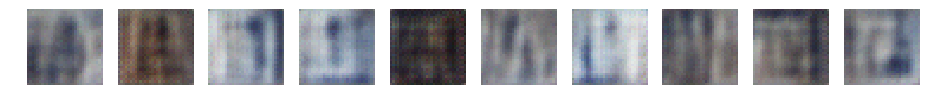

Epoch [    1/    5] | d_loss: 0.3864 | g_loss: 2.6604


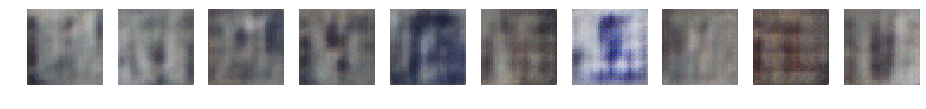

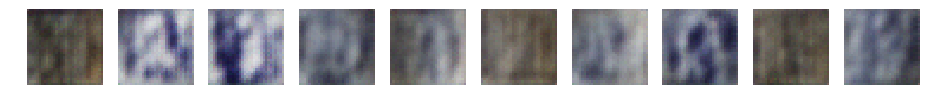

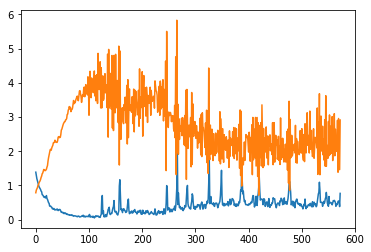

Epoch [    2/    5] | d_loss: 0.7833 | g_loss: 1.3468


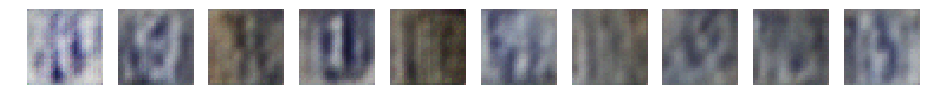

Epoch [    2/    5] | d_loss: 0.7210 | g_loss: 2.6778


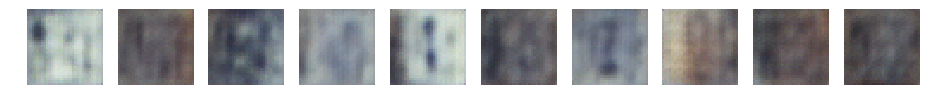

Epoch [    2/    5] | d_loss: 0.8388 | g_loss: 1.6093


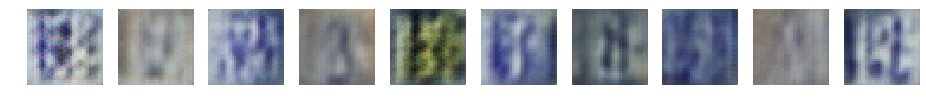

Epoch [    2/    5] | d_loss: 0.4626 | g_loss: 2.1084


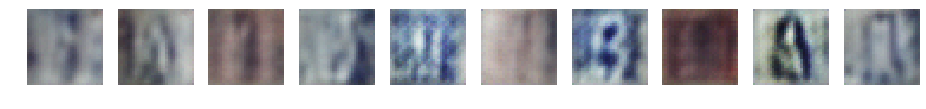

Epoch [    2/    5] | d_loss: 0.8858 | g_loss: 3.1196


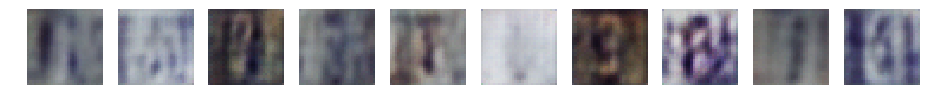

Epoch [    2/    5] | d_loss: 1.0710 | g_loss: 1.5888


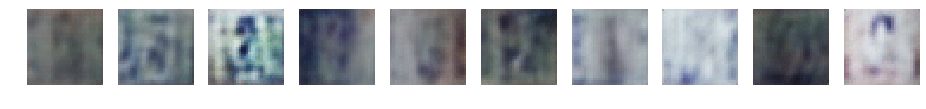

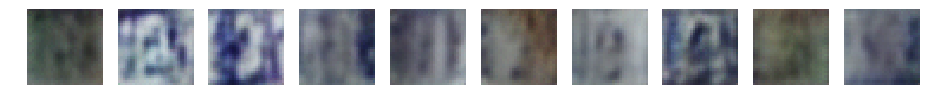

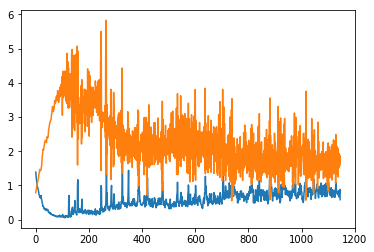

Epoch [    3/    5] | d_loss: 0.7114 | g_loss: 1.9634


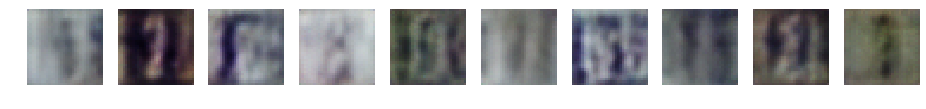

Epoch [    3/    5] | d_loss: 0.7168 | g_loss: 1.7354


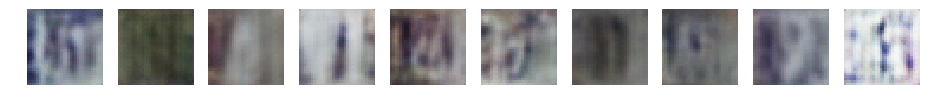

Epoch [    3/    5] | d_loss: 0.7209 | g_loss: 1.6826


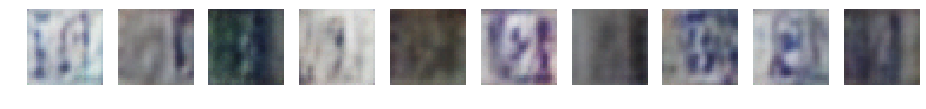

Epoch [    3/    5] | d_loss: 0.6633 | g_loss: 1.8602


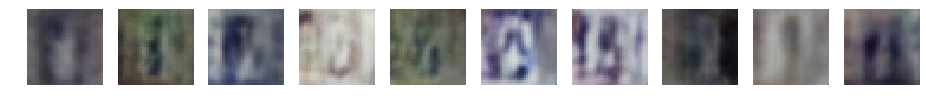

Epoch [    3/    5] | d_loss: 0.8238 | g_loss: 1.4431


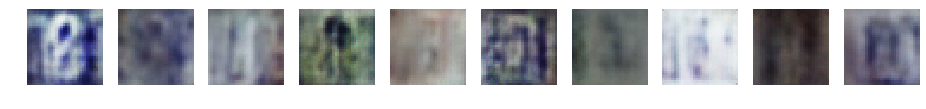

Epoch [    3/    5] | d_loss: 0.6227 | g_loss: 1.5938


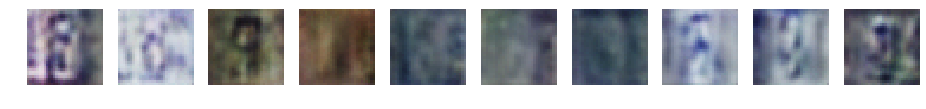

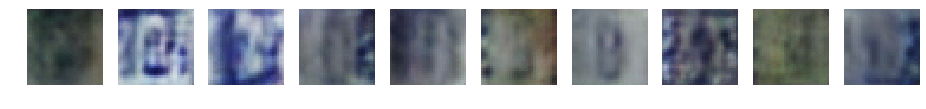

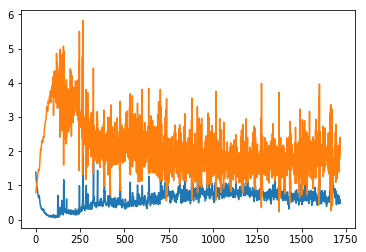

Epoch [    4/    5] | d_loss: 0.5722 | g_loss: 1.6105


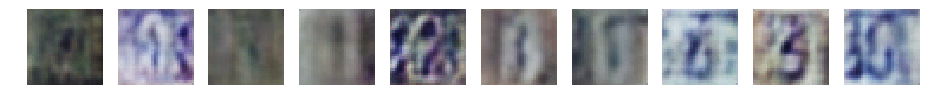

Epoch [    4/    5] | d_loss: 0.6930 | g_loss: 1.8047


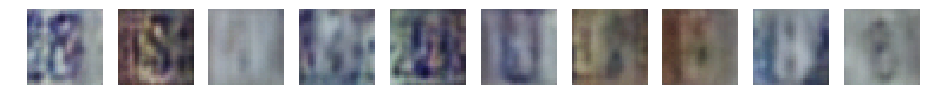

Epoch [    4/    5] | d_loss: 0.5147 | g_loss: 1.8308


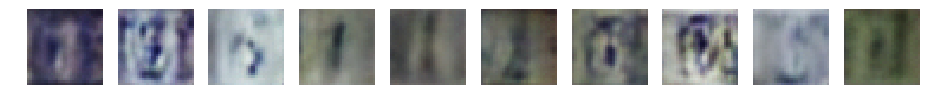

Epoch [    4/    5] | d_loss: 0.9096 | g_loss: 2.3981


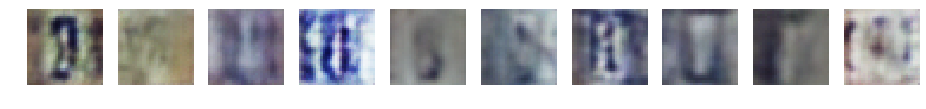

Epoch [    4/    5] | d_loss: 0.4243 | g_loss: 2.0024


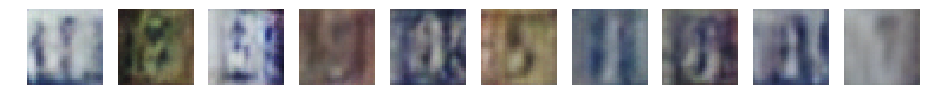

Epoch [    4/    5] | d_loss: 0.5424 | g_loss: 2.7222


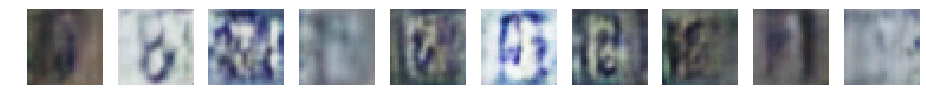

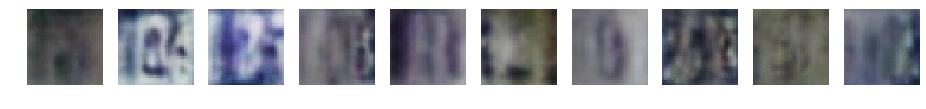

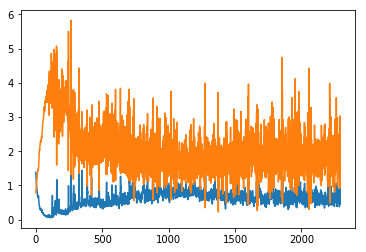

Epoch [    5/    5] | d_loss: 0.5964 | g_loss: 1.7940


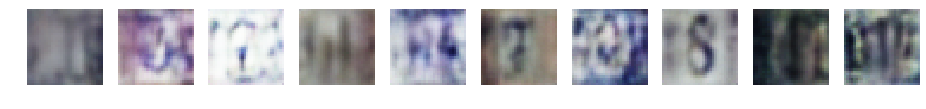

Epoch [    5/    5] | d_loss: 0.6189 | g_loss: 1.3223


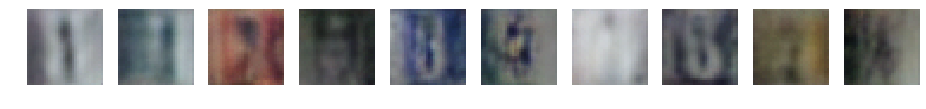

Epoch [    5/    5] | d_loss: 0.7257 | g_loss: 2.5624


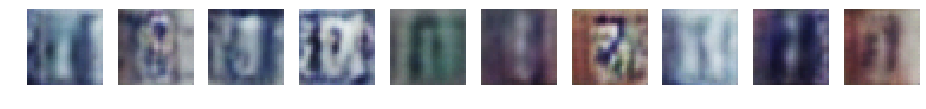

Epoch [    5/    5] | d_loss: 1.0027 | g_loss: 2.6059


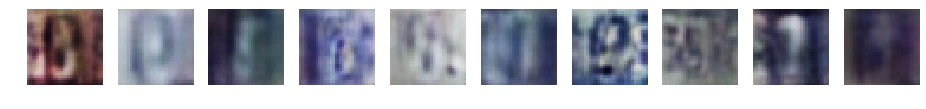

Epoch [    5/    5] | d_loss: 1.0034 | g_loss: 0.7395


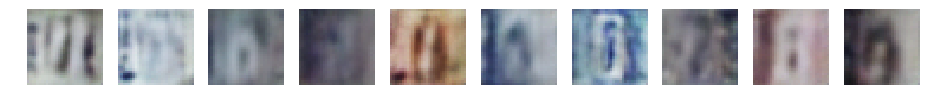

Epoch [    5/    5] | d_loss: 0.5300 | g_loss: 1.8822


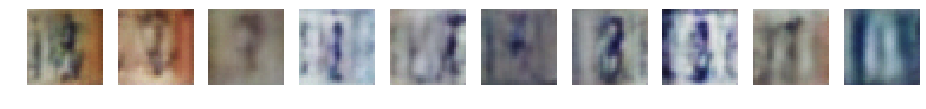

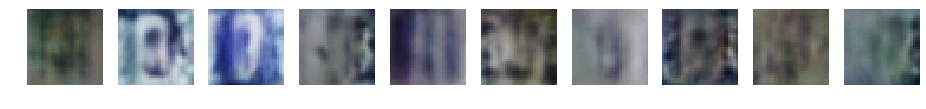

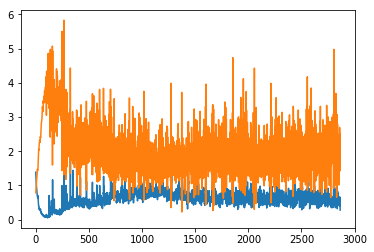

In [28]:
losses = {'gen':[], 'disc':[]}

############
# 

import pickle as pkl

# training hyperparams
num_epochs = 5

# keep track of loss and generated, "fake" samples
samples = []

print_every = 100

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(dataloader):
                
        batch_size = real_images.size(0)
        
        # important rescaling step
        #real_images = scale(real_images)
        
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        if train_on_gpu:
            real_images = real_images.cuda()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()
        
        # append discriminator loss and generator loss
        losses['disc'].append(d_loss.item())
        losses['gen'].append(g_loss.item())

        # Print some loss stats
        if batch_i % print_every == 0:
            
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))
            
            plot_images(fake_images)

    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode
    
    plot_images(samples_z)
    plot_loss(losses)



# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

In [29]:
raise

RuntimeError: No active exception to reraise

In [ ]:
############
# 
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
############
# 
for i in range(len(samples)):
    print(80*'=')
    print('epoch: ', i)
    _ = view_samples(i, samples)

# Reference

In [ ]:
############
# 
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
############
# 
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [ ]:
############
# 
for i in range(len(samples)):
    print(80*'=')
    print('epoch: ', i)
    _ = view_samples(i, samples)